# DRL Homework 3

Sophie Haas, Tjorven Weber, Johanna Linkemeyer

In [2]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils python-opengl ffmpeg > /dev/null 2>&1

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* colabgymrender

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Preparing the colab

In [3]:
%%bash

# install required system dependencies
# apt-get install -y xvfb x11-utils 
# python-opengl

# install required python dependencies (might need to install additional gym extras depending)
# pip install -U gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* colabgymrender

In [4]:
import pyvirtualdisplay

# initialize virtual display
_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900)) # use False with Xvfb
_ = _display.start()

In [5]:
import tensorflow as tf
import keras
from keras.activations import relu, linear
from keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

import collections
import numpy as np
import gym
from colabgymrender.recorder import Recorder
import matplotlib.pyplot as plt
import random

In [6]:
# Set up display

# from IPython import display as ipythondisplay
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(400, 300))
# display.start()

## Task 1: Experience Replay Buffer

The class ExperienceReplayBuffer uses [collections.deque](https://docs.python.org/3/library/collections.html#collections.deque) internally - which functions as a FIFO buffer: when a new element is added and the buffer would exceed its maximum length, the oldest items are deleted.

The class has a get_minibatch() function that returns a minibatch (of a given batch size) of random samples from the buffer.

In [7]:
class ExperienceReplayBuffer():

  def __init__(self, capacity):
    """
    Experience replay buffer with a max capacity of the capacity parameter. FIFO 
    style.
    """

    self.buffer = collections.deque(maxlen=capacity)
 
  def add_item(self, item):
    self.buffer.append(item)

  def get_minibatch(self, batch_size):

    # Sample minibatch from replay buffer
    minibatch = random.sample(self.buffer, batch_size)

    # get all tuples separated for minibatch and convert them to tensors each 
    # (for network processing)
    s, a, r, s_ = [], [], [], []
    for m in np.array(minibatch[:]):
      s.append(m[0])
      a.append(m[1])
      r.append(m[2])
      s_.append(m[3])
    
    s = tf.convert_to_tensor(s)
    a = tf.convert_to_tensor(a)
    r = tf.cast(tf.convert_to_tensor(r), dtype=tf.float32)
    s_ = tf.convert_to_tensor(s_)

    return s, a, r, s_


## 2. DQN

Our Deep Q-network is a sequential network consisting of three dense layers. The first two use a relu activation, the last one - the output layer - uses linear activation. The network can be initialized with input and output dimensions, where input dimensions refer to the state space dimensions and output dimensions to the number of actions possible.

In [8]:
from keras import Model
import keras.layers as layers

class NET(Model):

  def __init__(self, input_dim, output_dim):
    """
    A Q-network consisting of three dense layers
    """
    super(NET, self).__init__()
    self.input_layer = tf.keras.layers.InputLayer(input_shape=input_dim)
    self.dense_1 = tf.keras.layers.Dense(units=512, activation='relu')
    self.dense_2 = tf.keras.layers.Dense(units=256, activation='relu')
    self.out = tf.keras.layers.Dense(units=output_dim, activation='linear')
  
  @tf.function
  def __call__(self, input):
    x = self.input_layer(input)
    x = self.dense_1(x)
    x = self.dense_2(x)
    x = self.out(x)

    return x

## 3. DQN Training

This version uses a delayed target network (TARGET_NET) that is set to the q-network (Q_NET) every N * K * batch-size steps. 

In [14]:
# Parameter settings
ENV = gym.make("LunarLander-v2")
ENV = Recorder(ENV, './video')
BATCH_SIZE = 16
REPLAY_BUFFER = ExperienceReplayBuffer(capacity=100000)
GAMMA = 0.99
EPISODES = 10

MSE_DQN = tf.losses.MeanSquaredError()
ADAM = tf.keras.optimizers.Adam(learning_rate=0.001)

Q_NET = NET(ENV.observation_space.shape[0], ENV.action_space.n)
TARGET_NET = NET(ENV.observation_space.shape[0], ENV.action_space.n)

N = 100
K = 100

In [23]:
def train_qnet():
  """
  """

  # setup 
  tf.keras.backend.clear_session()
  ENV.seed(0)
  np.random.seed(0)

  returns = []
  losses = []

  for episode in np.arange(EPISODES):

    print(f"STARTING EPSIODE {episode}...")

    TARGET_NET.set_weights(Q_NET.get_weights()) # delay the target network

    for _ in np.arange(N):
      
      # Start a new episode
      current_state = ENV.reset()
      reward_sum = 0

      for step in np.arange(K): # Maximum num of steps

        # Sample (s, a, r, s') from env and add to replay buffer
        action = ENV.action_space.sample()
        next_state, reward, done, info = ENV.step(action)
        REPLAY_BUFFER.add_item((current_state, action, reward, next_state))
        reward_sum = reward_sum + reward

        if len(REPLAY_BUFFER.buffer) >= BATCH_SIZE:

          # Sample minibatch from replay buffer
          states, actions, rewards, next_states = REPLAY_BUFFER.get_minibatch(BATCH_SIZE)

          with tf.GradientTape() as t:
            
            predictions = Q_NET(states)
            indices = tf.stack([tf.range(BATCH_SIZE), actions], axis=1)

            next = tf.cast(tf.math.reduce_max(TARGET_NET(next_states)), 
                           dtype=tf.float32)

            loss = MSE_DQN(tf.gather_nd(predictions, indices), 
                           tf.math.add(rewards, tf.math.multiply(GAMMA, next))) # mse between current prediction and target thingy

          gradients = t.gradient(loss, Q_NET.trainable_variables)
          ADAM.apply_gradients(zip(gradients, Q_NET.trainable_variables))
        
        if done: # stop episode if terminal state is reached
          break

        current_state = next_state

    try:
      ENV.play()
    except:
      print("Caught")

    returns.append(reward_sum)
    losses.append(loss)
    print(f"--> rewards: {reward_sum}")
    print(f"--> loss: {loss}")
  
  ENV.close()

  return returns, losses

In [24]:
dqn_returns, dqn_returns = train_qnet()

STARTING EPSIODE 0...


--> rewards: -94.39528406406016
--> loss: 19.823654174804688
STARTING EPSIODE 1...


--> rewards: -149.3211976102681
--> loss: 35.49311828613281
STARTING EPSIODE 2...


--> rewards: -222.76074783088185
--> loss: 16.57073402404785
STARTING EPSIODE 3...


--> rewards: -109.06041178938558
--> loss: 33.23440170288086
STARTING EPSIODE 4...
Caught
--> rewards: -64.60673623212944
--> loss: 46.75511932373047
STARTING EPSIODE 5...


--> rewards: -246.4024676111883
--> loss: 137.80062866210938
STARTING EPSIODE 6...


--> rewards: -399.9250289575633
--> loss: 24.307689666748047
STARTING EPSIODE 7...
Caught
--> rewards: -23.50712446159069
--> loss: 13.508225440979004
STARTING EPSIODE 8...


--> rewards: -146.70402944497107
--> loss: 101.58307647705078
STARTING EPSIODE 9...


--> rewards: -113.13457612504695
--> loss: 261.2012634277344


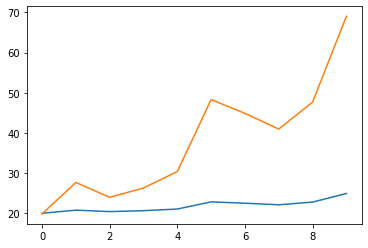

In [25]:
average_returns = []
summed_returns = np.cumsum(np.asarray(dqn_returns))
estimations = summed_returns/np.arange(1,EPISODES+1)
biased_estimations = estimations*0.1 + 20*0.9

plt.plot(biased_estimations)
plt.plot(estimations)
plt.show()

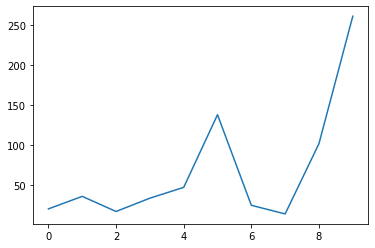

In [26]:
plt.plot(np.array(dqn_returns))
plt.show()